# Plot audio voltage

This notebook plots the voltage of a badge based on the voltage stored in an audio samples file. Can be used for measuring badge battery usage and total run time. Here, we use it for comparing a badge with an old firmware, and a badge with the new firmware (2.0)

New badge (firmware 2.0) - D4:E4:47:A5:F0:B3

old badge - E7:00:28:A7:DB:C2

In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys
import datetime
import pandas as pd
import numpy as np
import pytz
import dateutil
#import seaborn as sns
#sns.set(style="whitegrid")
from ggplot import *
import gzip

%matplotlib inline

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir)
sys.path.append(src_dir)

# import data analysis modules
import openbadge_analysis as ob

In [2]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# list of modules to autoload
%aimport openbadge_analysis

In [3]:
filename = '/home/orenled/temp/logs/4_log_audio.txt.gz'
with gzip.open(filename, 'r') as f:
    audio_chunks = ob.load_audio_chunks_as_json_objects(f, log_version='2.0')

In [4]:
# load data into a data frame
df_audio_voltage = pd.DataFrame(audio_chunks,columns=['badge_address','timestamp','voltage'])
print(df_audio_voltage.head())

# Converting timestamp (epoch) to UTC datetime
df_audio_voltage['datetime'] = pd.to_datetime(df_audio_voltage['timestamp'],unit='s', utc=True)
print(df_audio_voltage.dtypes)

       badge_address     timestamp  voltage
0  CE:05:A0:D6:8C:80  1.483031e+09    3.121
1  F2:37:E3:BA:70:9D  1.483031e+09    3.234
2  CE:05:A0:D6:8C:80  1.483031e+09    3.121
3  CE:05:A0:D6:8C:80  1.483031e+09    3.121
4  CE:05:A0:D6:8C:80  1.483031e+09    3.121
badge_address            object
timestamp               float64
voltage                 float64
datetime         datetime64[ns]
dtype: object


In [5]:
#print(df_audio_voltage[df_audio_voltage['badge_address']=='D4:E4:47:A5:F0:B3'])
#df_audio_voltage=df_audio_voltage[df_audio_voltage['badge_address']=='D4:E4:47:A5:F0:B3']

# Sainty check

In [6]:
# min/max values
df_group_by_badge = df_audio_voltage.reset_index().groupby('badge_address')
print("Max:\n",df_group_by_badge.max(),"\n")
print("Min:\n",df_group_by_badge.min())

Max:
                     index     timestamp  voltage                datetime
badge_address                                                           
CE:05:A0:D6:8C:80  138720  1.483319e+09    3.164 2017-01-02 01:03:50.129
F2:37:E3:BA:70:9D  198185  1.483536e+09    3.234 2017-01-04 13:26:34.512 

Min:
                    index     timestamp  voltage                datetime
badge_address                                                          
CE:05:A0:D6:8C:80      0  1.483031e+09    2.182 2016-12-29 17:07:34.676
F2:37:E3:BA:70:9D      1  1.483031e+09    2.046 2016-12-29 17:07:37.963


In [7]:
# Nans?
print(len(df_audio_voltage))
print(df_audio_voltage[np.isnan(df_audio_voltage['voltage'])])
print(df_audio_voltage[np.isnan(df_audio_voltage['timestamp'])])
print(df_audio_voltage[df_audio_voltage['datetime'].isnull()])
print(df_audio_voltage[df_audio_voltage['badge_address'].isnull()])

198186
Empty DataFrame
Columns: [badge_address, timestamp, voltage, datetime]
Index: []
Empty DataFrame
Columns: [badge_address, timestamp, voltage, datetime]
Index: []
Empty DataFrame
Columns: [badge_address, timestamp, voltage, datetime]
Index: []
Empty DataFrame
Columns: [badge_address, timestamp, voltage, datetime]
Index: []


# show voltage graphs

In [8]:
# Setting datetime as index
df_audio_voltage.sort_values('datetime')
df_audio_voltage.index = pd.to_datetime(df_audio_voltage.pop('datetime'), utc=True)
df_audio_voltage = df_audio_voltage.tz_localize('UTC')
print(df_audio_voltage.head())
del df_audio_voltage['timestamp']
print(df_audio_voltage.index[0]) # UTC

                                      badge_address     timestamp  voltage
datetime                                                                  
2016-12-29 17:07:34.676000+00:00  CE:05:A0:D6:8C:80  1.483031e+09    3.121
2016-12-29 17:07:37.963000+00:00  F2:37:E3:BA:70:9D  1.483031e+09    3.234
2016-12-29 17:07:34.676000+00:00  CE:05:A0:D6:8C:80  1.483031e+09    3.121
2016-12-29 17:07:40.377000+00:00  CE:05:A0:D6:8C:80  1.483031e+09    3.121
2016-12-29 17:07:46.077000+00:00  CE:05:A0:D6:8C:80  1.483031e+09    3.121
2016-12-29 17:07:34.676000+00:00


In [9]:
# http://pandas.pydata.org/pandas-docs/stable/cookbook.html
# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#aggregation
df_grouped = df_audio_voltage.groupby('badge_address')
df_resampled = df_grouped.resample('5S').mean().ffill()
print(df_resampled.head())
print(type(df_resampled))

df_flat = df_resampled.reset_index()
print(df_flat.head())


                                             voltage
badge_address     datetime                          
CE:05:A0:D6:8C:80 2016-12-29 17:07:30+00:00    3.121
                  2016-12-29 17:07:35+00:00    3.121
                  2016-12-29 17:07:40+00:00    3.121
                  2016-12-29 17:07:45+00:00    3.121
                  2016-12-29 17:07:50+00:00    3.121
<class 'pandas.core.frame.DataFrame'>
       badge_address                  datetime  voltage
0  CE:05:A0:D6:8C:80 2016-12-29 17:07:30+00:00    3.121
1  CE:05:A0:D6:8C:80 2016-12-29 17:07:35+00:00    3.121
2  CE:05:A0:D6:8C:80 2016-12-29 17:07:40+00:00    3.121
3  CE:05:A0:D6:8C:80 2016-12-29 17:07:45+00:00    3.121
4  CE:05:A0:D6:8C:80 2016-12-29 17:07:50+00:00    3.121


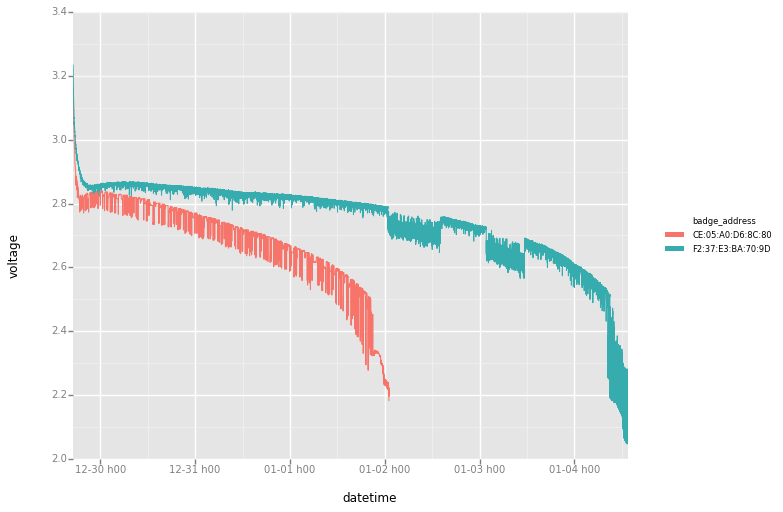

<ggplot: (8739034754033)>

In [10]:
ggplot(aes(x='datetime', y='voltage', color='badge_address'), data=df_flat) +\
    geom_line()+ scale_x_date(labels='%m-%d h%H') #+ theme(x_axis_text=element_text(angle=45)) 

# Dealing with timezones

In [11]:
# want to convert to Eastern time?
# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#time-zone-handling
eastern = pytz.timezone('US/Eastern')
df_audio_voltage_local = df_audio_voltage.tz_convert(eastern)
print(df_audio_voltage_local.head())
print(df_audio_voltage_local.index)
print("-----------------------")
df_resampled_local = df_resampled.tz_convert(eastern, level=1)
print(df_resampled_local.head())
print(df_resampled_local.index[0])
print("-----------------------")
df_flat_local = df_resampled_local.reset_index()
print(df_flat_local.head())
print(df_flat_local[0:5]['datetime']) # still correct timezone

                                      badge_address  voltage
datetime                                                    
2016-12-29 12:07:34.676000-05:00  CE:05:A0:D6:8C:80    3.121
2016-12-29 12:07:37.963000-05:00  F2:37:E3:BA:70:9D    3.234
2016-12-29 12:07:34.676000-05:00  CE:05:A0:D6:8C:80    3.121
2016-12-29 12:07:40.377000-05:00  CE:05:A0:D6:8C:80    3.121
2016-12-29 12:07:46.077000-05:00  CE:05:A0:D6:8C:80    3.121
DatetimeIndex(['2016-12-29 12:07:34.676000-05:00',
               '2016-12-29 12:07:37.963000-05:00',
               '2016-12-29 12:07:34.676000-05:00',
               '2016-12-29 12:07:40.377000-05:00',
               '2016-12-29 12:07:46.077000-05:00',
               '2016-12-29 12:07:37.963000-05:00',
               '2016-12-29 12:07:43.685000-05:00',
               '2016-12-29 12:07:49.383000-05:00',
               '2016-12-29 12:07:49.383000-05:00',
               '2016-12-29 12:07:55.082000-05:00',
               ...
               '2017-01-04 08:26:11.715000-0

In [12]:
print(df_flat_local[:5])

       badge_address                  datetime  voltage
0  CE:05:A0:D6:8C:80 2016-12-29 12:07:30-05:00    3.121
1  CE:05:A0:D6:8C:80 2016-12-29 12:07:35-05:00    3.121
2  CE:05:A0:D6:8C:80 2016-12-29 12:07:40-05:00    3.121
3  CE:05:A0:D6:8C:80 2016-12-29 12:07:45-05:00    3.121
4  CE:05:A0:D6:8C:80 2016-12-29 12:07:50-05:00    3.121


## for ggplot, you need to use dateutil timezones

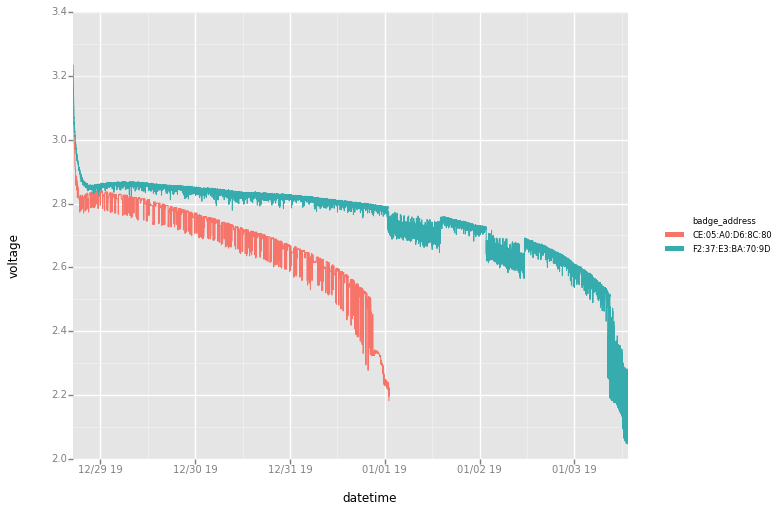

<ggplot: (8738989386801)>

In [13]:
tz_dateutil_est = dateutil.tz.gettz('US/Eastern')

ggplot(aes(x='datetime', y='voltage', color='badge_address'), data=df_flat) +\
    geom_line()+ scale_x_date(labels = date_format("%m/%d %H", tz = tz_dateutil_est))